<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Проба-классификации" data-toc-modified-id="Проба-классификации-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Проба классификации</a></span></li><li><span><a href="#Проба-регрессии!" data-toc-modified-id="Проба-регрессии!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проба регрессии!</a></span><ul class="toc-item"><li><span><a href="#Проверка,-что-дает-на-доске-наша-проба-пера" data-toc-modified-id="Проверка,-что-дает-на-доске-наша-проба-пера-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка, что дает на доске наша проба пера</a></span></li></ul></li><li><span><a href="#2-этап,-подбор" data-toc-modified-id="2-этап,-подбор-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2 этап, подбор</a></span><ul class="toc-item"><li><span><a href="#Регрессия" data-toc-modified-id="Регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Регрессия</a></span></li><li><span><a href="#Подбор-классификации" data-toc-modified-id="Подбор-классификации-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подбор классификации</a></span></li></ul></li><li><span><a href="#ФИНАЛЬНОЕ-ПРЕДСКАЗАНИЕ" data-toc-modified-id="ФИНАЛЬНОЕ-ПРЕДСКАЗАНИЕ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ФИНАЛЬНОЕ ПРЕДСКАЗАНИЕ</a></span></li></ul></div>

Это версия того же ноутбука с почищенным выводом некоторых ячеек, из которых не рендерилось представление на гитхабе!!!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install catboost
! pip install optuna

In [4]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
#import re
import seaborn as sns
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import make_scorer, recall_score, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import  KFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
#from sklearn.preprocessing import OrdinalEncoder


warnings.simplefilter(action='ignore')

In [5]:
types_full = {
 'ticket_id': 'category',
 'ticket_type_nm': 'category',
 'station_id': 'category',
 'time_to_under': 'float64',
 'label': 'int64',
 'passenger_category': 'category',
 'day_valid': 'category',
 'time_valid': 'int64',
 'count_of_trips': 'int64',
 'mean_time_valid': 'float64',
 'std_day_valid': 'float64',
 'std_time_valid': 'float64',
 'var_day_valid': 'float64',
 'var_time_valid': 'float64',
 'n_station_id': 'int64'}

In [6]:
#show all columns and rows in pamdas:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# Считаем наши данные
pth1 = '/content/drive/MyDrive/amur/X_full.csv' # серверный путь
pth2 = 'X_full.csv' # Локальный путь

if os.path.exists(pth1):
    df = pd.read_csv(pth1, dtype=types_full, index_col='id')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, dtype=types_full, index_col='id')
else:
    print('Something is wrong')  

In [8]:
X_full = df.copy()

In [9]:
X_full.head()

,ticket_id,ticket_type_nm,station_id,time_to_under,label,passenger_category,day_valid,time_valid,count_of_trips,mean_time_valid,std_day_valid,std_time_valid,var_day_valid,var_time_valid,n_station_id
id,,,,,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,facepay,11007,216.316667,8001,simple,0,18013,1,18013.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,1
2,126727A96489CC976A8C08E5CEB00542,school_30,2006,648.183333,9011,schoolars,0,18054,5,36682.600000,2.549510,15008.832943,6.500000,2.252651e+08,1
3,D28CE6A9E0E5B6D213470A97CFF32485,druzhina,2006,865.333333,7022,other,0,18055,5,36198.800000,2.236068,13871.974668,5.000000,1.924317e+08,1
4,015DA44B523C062B5BFEFF3FB0E64B9E,simple_30,2006,1048.233333,2022,simple,0,18073,6,38681.333333,2.316607,10313.346667,5.366667,1.063651e+08,2
5,95B19C6F3A504727AC3EA56EB7E3E80F,wallet,2006,965.600000,2017,simple,0,18175,4,36340.000000,2.629956,13741.081423,6.916667,1.888173e+08,1


In [10]:
X_full.duplicated().sum()

0

In [11]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 1 to 1091021
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   ticket_id           1091021 non-null  category
 1   ticket_type_nm      1091021 non-null  category
 2   station_id          1091021 non-null  category
 3   time_to_under       1091021 non-null  float64 
 4   label               1091021 non-null  int64   
 5   passenger_category  1091021 non-null  category
 6   day_valid           1091021 non-null  category
 7   time_valid          1091021 non-null  int64   
 8   count_of_trips      1091021 non-null  int64   
 9   mean_time_valid     1091021 non-null  float64 
 10  std_day_valid       1091021 non-null  float64 
 11  std_time_valid      1091021 non-null  float64 
 12  var_day_valid       1091021 non-null  float64 
 13  var_time_valid      1091021 non-null  float64 
 14  n_station_id        1091021 non-null  int64   
dty

In [12]:
def my_score_func_c(y_real, preds):
    return recall_score(y_real, preds,  average = "macro")

my_scorer_c = make_scorer(my_score_func_c, greater_is_better=True)

In [13]:
def my_score_func_r(y_real, preds):
    return r2_score(y_real, preds)

my_scorer_r = make_scorer(my_score_func_r, greater_is_better=True)

## Проба классификации

In [14]:
y_c = X_full.label
y_r = X_full.time_to_under
X_full.drop(['label', 'time_to_under', 'ticket_id'], axis=1, inplace=True, errors='ignore')

In [15]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 1 to 1091021
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   ticket_type_nm      1091021 non-null  category
 1   station_id          1091021 non-null  category
 2   passenger_category  1091021 non-null  category
 3   day_valid           1091021 non-null  category
 4   time_valid          1091021 non-null  int64   
 5   count_of_trips      1091021 non-null  int64   
 6   mean_time_valid     1091021 non-null  float64 
 7   std_day_valid       1091021 non-null  float64 
 8   std_time_valid      1091021 non-null  float64 
 9   var_day_valid       1091021 non-null  float64 
 10  var_time_valid      1091021 non-null  float64 
 11  n_station_id        1091021 non-null  int64   
dtypes: category(4), float64(5), int64(3)
memory usage: 80.1 MB


In [16]:
X_full.drop(['ticket_type_nm'], axis=1, inplace=True, errors='ignore')

In [17]:
cat_cols = [col for col in X_full.columns if X_full[col].dtype=='category']
cat_cols

['station_id', 'passenger_category', 'day_valid']

In [18]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_full, y_c, test_size=0.23, stratify=y_c)

In [19]:
X_train1.shape

(840086, 11)

In [20]:
y_train1.mean()

7723.567707353771

In [21]:
y_train1.nunique()

276

In [22]:
X_valid1.shape

(250935, 11)

In [23]:
y_valid1.mean()

7723.38990176739

In [24]:
y_valid1.nunique()

276

In [25]:
classes = np.unique(y_c)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_c)
class_weights = dict(zip(classes, weights))
#class_weights

In [ ]:
model = CatBoostClassifier(loss_function="MultiClass",  verbose=False, random_state=11,
                           task_type='GPU', gpu_ram_part=0.96, max_depth=3, cat_features=cat_cols,
                           one_hot_max_size=5, auto_class_weights='balanced', n_estimators=300)

In [ ]:
model.fit(X_train1, y_train1, eval_set=[(X_valid1, y_valid1)], early_stopping_rounds=99, verbose=False)

In [ ]:
preds = model.predict(X_valid1)

In [ ]:
my_score_func_c(y_valid1, preds)

0.011515717003572068

## Проба регрессии!

In [ ]:
X_full = df.copy()
y_c = X_full.label
y_r = X_full.time_to_under
X_full.drop(['label', 'time_to_under', 'ticket_id'], axis=1, inplace=True, errors='ignore')

In [ ]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_full, y_r, test_size=0.3)

In [ ]:
cat_cols = [col for col in X_full.columns if X_full[col].dtype=='category']
cat_cols

['ticket_type_nm', 'station_id', 'passenger_category', 'day_valid']

In [ ]:
model_r = CatBoostRegressor(loss_function="RMSE",  verbose=False, random_state=11,
                            gpu_ram_part=0.96, max_depth=3, cat_features=cat_cols,
                           one_hot_max_size=10, eval_metric='R2',  task_type='GPU')

In [ ]:
gc.collect()

193

In [ ]:
model_r.fit(X_train2, y_train2, eval_set=[(X_valid2, y_valid2)], early_stopping_rounds=99, verbose=False)

In [ ]:
preds_r = model_r.predict(X_valid2)

In [ ]:
my_score_func_r(y_valid2, preds_r)

0.5778066151730168

### Проверка, что дает на доске наша проба пера

In [28]:
df_test = pd.read_csv('/content/drive/MyDrive/amur/X_test.csv', dtype=types_full, index_col='id')

In [29]:
X_test = df_test.copy()

In [30]:
X_test.head()

,ticket_id,ticket_type_nm,station_id,passenger_category,day_valid,time_valid,count_of_trips,mean_time_valid,std_day_valid,std_time_valid,var_day_valid,var_time_valid,n_station_id
id,,,,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,wallet,2006,simple,0,18003,4,29203.750000,1.825742,8605.954697,3.333333,7.406246e+07,1
1091023,F94EDC107A4E054786882F9453C1B93F,facepay,3010,simple,0,18045,3,33967.000000,1.527525,23012.525698,2.333333,5.295763e+08,2
1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,student_30,2006,students,0,18052,6,39320.166667,2.160247,14828.942018,4.666667,2.198975e+08,1
1091025,7B98691636EC418ABF6FEDDE4D7C68FC,wallet,2018,simple,0,18058,3,36184.333333,2.516611,22732.768778,6.333333,5.167788e+08,2
1091026,679C55C28CB36FB546FD104502C0B3DB,wallet,2006,simple,0,18099,2,29273.000000,0.707107,15802.422346,0.500000,2.497166e+08,1


In [31]:
X_test.drop('ticket_id', axis=1, inplace=True)

In [32]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561890 entries, 1091022 to 1652911
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ticket_type_nm      561890 non-null  category
 1   station_id          561890 non-null  category
 2   passenger_category  561890 non-null  category
 3   day_valid           561890 non-null  category
 4   time_valid          561890 non-null  int64   
 5   count_of_trips      561890 non-null  int64   
 6   mean_time_valid     561890 non-null  float64 
 7   std_day_valid       561890 non-null  float64 
 8   std_time_valid      561890 non-null  float64 
 9   var_day_valid       561890 non-null  float64 
 10  var_time_valid      561890 non-null  float64 
 11  n_station_id        561890 non-null  int64   
dtypes: category(4), float64(5), int64(3)
memory usage: 41.3 MB


In [ ]:
model.get_params()

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,station_id,71.791016
1,time_valid,28.208984
2,passenger_category,0.000000
3,day_valid,0.000000
4,count_of_trips,0.000000
5,mean_time_valid,0.000000
6,std_day_valid,0.000000
7,std_time_valid,0.000000
8,var_day_valid,0.000000
9,var_time_valid,0.000000


In [ ]:
y_test_c = model.predict(X_test.drop('ticket_type_nm', axis=1))

In [ ]:
model_r.fit(X_full, y_r)

In [ ]:
model_r.get_feature_importance(prettified=True)

,Feature Id,Importances
0,time_valid,66.462662
1,count_of_trips,9.957220
2,passenger_category,5.927217
3,mean_time_valid,3.489259
4,ticket_type_nm,3.467426
5,std_time_valid,3.149244
6,var_time_valid,3.070278
7,day_valid,2.265842
8,var_day_valid,0.676823
9,std_day_valid,0.632041


In [ ]:
y_test_r = model_r.predict(X_test)

In [ ]:
solution = pd.DataFrame(y_test_r, index=X_test.index, columns=['time_to_under']).reset_index()

solution['label'] = y_test_c
display(solution.head())

#display(X_test.head())

solution.to_csv("/content/drive/MyDrive/amur/amur_test2.csv",sep=",", index=False, line_terminator='\n')

,id,time_to_under,label
0,1091022,670.860317,11021
1,1091023,414.223427,11021
2,1091024,637.343814,11021
3,1091025,623.011156,11021
4,1091026,680.783772,11021


In [ ]:
solution.shape

(561890, 3)

На доске дало 0.293 - движемся правильно

## 2 этап, подбор

### Регрессия

In [ ]:
def objective(trial, X_train=X_train2, X_valid=X_valid2, y_train=y_train2, y_valid = y_valid2, cat_cols=cat_cols):
    learn_pool = Pool(
        X_train, 
        y_train, 
        cat_features=cat_cols,
        feature_names=list(X_train)
    )
    valid_pool = Pool(
        X_valid, 
        y_valid, 
        cat_features=cat_cols,
        feature_names=list(X_train)
    )
    param = {
        #'cat_features': cat_cols,
        'one_hot_max_size': 10,
        'verbose': False,
        #'loss_function': 'Logloss',
        'task_type': 'GPU',
        'gpu_ram_part': 0.96,
        'loss_function': trial.suggest_categorical("los_function", ['RMSE']),
        #'auto_class_weights': trial.suggest_categorical("auto_class_weights", ["Balanced"]),
        #"objective": trial.suggest_categorical("objective", ["Logloss"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 9),
        # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"]),#"Bayesian", "MVS"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators':  trial.suggest_int('n_estimators', 150, 2000),
        'max_depth': trial.suggest_categorical('max_depth', [4, 5 ,6, 7, 8, 9, 10, 11, 12,
                                                             13, 14, 15, 16]),
        'random_state': trial.suggest_categorical('random_state', [11]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        #'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        #'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0)
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)
    
    #cv=StratifiedKFold(n_splits=5, random_state=23071983, shuffle=True)
    
    model = CatBoostRegressor(**param)  
    model.fit(learn_pool, eval_set=valid_pool, early_stopping_rounds=99, verbose=False)
    preds = model.predict(X_valid)
    score = my_score_func_r(y_valid, preds)
    
    return score #cross_val_score(model, X_train, y_train,cv=cv,scoring=my_scorer, verbose=False).mean()

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.  (n_warmup_steps=9))
study.optimize(objective, n_trials=3333, timeout=15372)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.best_value

[I 2022-11-23 08:16:40,056] A new study created in memory with name: no-name-d68f1a4a-2465-4a73-a0f2-7d8a304b2b80
[I 2022-11-23 08:17:43,817] Trial 0 finished with value: 0.5817048881582194 and parameters: {'los_function': 'RMSE', 'l2_leaf_reg': 3.991445150139619, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.08062441599401791, 'n_estimators': 1406, 'max_depth': 5, 'random_state': 11, 'min_data_in_leaf': 68, 'subsample': 0.30035681540004877}. Best is trial 0 with value: 0.5817048881582194.
[I 2022-11-23 08:18:53,187] Trial 1 finished with value: 0.582739015067298 and parameters: {'los_function': 'RMSE', 'l2_leaf_reg': 8.794936933970988, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.042746627376066, 'n_estimators': 437, 'max_depth': 12, 'random_state': 11, 'min_data_in_leaf': 22, 'subsample': 0.15236564887173396}. Best is trial 1 with value: 0.582739015067298.
[I 2022-11-23 08:30:06,689] Trial 2 finished with value: 0.5924111317506984 and parameters: {'los_function': 'RMSE', 'l2

Number of finished trials: 51
Best trial: {'los_function': 'RMSE', 'l2_leaf_reg': 1.1861471510622876, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.07958600472584267, 'n_estimators': 1881, 'max_depth': 13, 'random_state': 11, 'min_data_in_leaf': 35, 'subsample': 0.9943290956143191}


0.6070569669981238

Number of finished trials: 51
Best trial: {'los_function': 'RMSE', 'l2_leaf_reg': 1.1861471510622876, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.07958600472584267, 'n_estimators': 1881, 'max_depth': 13, 'random_state': 11, 'min_data_in_leaf': 35, 'subsample': 0.9943290956143191}
0.6070569669981238

In [59]:
X_full = df.copy()
y_c = X_full.label
y_r = X_full.time_to_under
X_full.drop(['label', 'time_to_under', 'ticket_id'], axis=1, inplace=True, errors='ignore')

In [60]:
cat_cols = [col for col in X_full.columns if X_full[col].dtype=='category']
cat_cols

['ticket_type_nm', 'station_id', 'passenger_category', 'day_valid']

In [61]:
b_p =  {'loss_function': 'RMSE', 'l2_leaf_reg': 1.1861471510622876, 'bootstrap_type': 'Bernoulli',
        'learning_rate': 0.07958600472584267, 'n_estimators': 1881, 'max_depth': 13, 'random_state': 11,
        'min_data_in_leaf': 35, 'subsample': 0.9943290956143191, 'one_hot_max_size': 10, 'verbose': False,
        'task_type': 'GPU', 'gpu_ram_part': 0.96, 'cat_features': cat_cols}

In [65]:
gc.collect()

1567

In [15]:
#немного бэггинга для тестовых данных

In [66]:
y_test = np.zeros(X_test.shape[0])
kf = KFold(n_splits=10, random_state=11, shuffle=True)
myscore=[]   # list contains my_score for each fold
n=0
for trn_idx, test_idx in kf.split(X_full, y_r):
    X_tr, X_val = X_full.iloc[trn_idx], X_full.iloc[test_idx]
    y_tr, y_val = y_r.iloc[trn_idx], y_r.iloc[test_idx]
    model = CatBoostRegressor(**b_p)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=99, verbose=False)
    preds = model.predict(X_test)
    y_test += preds / kf.n_splits
    myscore.append(my_score_func_r(y_val, model.predict(X_val)))
    print(f"fold: {n+1} ==> my_score: {myscore[n]}")
    n+=1

fold: 1 ==> my_score: 0.6150363324665769
fold: 2 ==> my_score: 0.6170516786889546
fold: 3 ==> my_score: 0.6132692152639447
fold: 4 ==> my_score: 0.6162607029863818
fold: 5 ==> my_score: 0.6165071568994794
fold: 6 ==> my_score: 0.6165772724551911
fold: 7 ==> my_score: 0.6123438458676873
fold: 8 ==> my_score: 0.616731217571882
fold: 9 ==> my_score: 0.6139228400646609
fold: 10 ==> my_score: 0.6119146920642947


In [67]:
y_test

array([663.24299752, 345.85813821, 541.67448084, ..., 150.17111047,
       454.26289848, 501.7916504 ])

In [71]:
solution_r = pd.DataFrame(y_test, index=X_test.index, columns=['time_to_under']).reset_index()

#solution['label'] = y_test
display(solution_r.head())

#display(X_test.head())

solution_r.to_csv("/content/drive/MyDrive/amur/amur_sol_3.csv",sep=",", index=False, line_terminator='\n')

,id,time_to_under
0,1091022,663.242998
1,1091023,345.858138
2,1091024,541.674481
3,1091025,710.153393
4,1091026,623.774560


### Подбор классификации

In [25]:
import lightgbm as lgbm
print(lgbm.__version__)

3.3.2


In [ ]:
def objective_lg(trial, X_train=X_train1, X_valid=X_valid1, y_train=y_train1, y_valid = y_valid1, cat_cols=cat_cols):

    param_grid = {
        #"device_type": 'gpu',
        "n_estimators": trial.suggest_int("n_estimators", 20, 3000, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 10, step=1),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 10, step=1),
        "min_split_gain": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.1, 1, step=0.1
        ),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.1, 1, step=0.1
        ),
    }

    model = lgbm.LGBMClassifier(objective='multiclass',  verbose=-1, random_state=11,
                          device_type='gpu', class_weight='balanced', **param_grid)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=99,
              verbose=-1, categorical_feature=cat_cols)
              #callbacks=[LightGBMPruningCallback(trial, "multi_logloss")])
    
    preds = model.predict(X_valid)
    score = my_score_func_c(y_valid, preds)
    
    return score #cross_val_score(model, X_train, y_train,cv=cv,scoring=my_scorer, verbose=False).mean()

In [50]:
study_lg = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=9))
study_lg.optimize(objective_lg, n_trials=3333, timeout=32400)
print('Number of finished trials:', len(study_lg.trials))
print('Best trial:', study_lg.best_trial.params)
study_lg.best_value

[I 2022-11-23 21:59:22,414] A new study created in memory with name: no-name-42d49aa0-2dfa-42ce-ac76-212391846f25
[I 2022-11-24 00:13:29,749] Trial 0 finished with value: 0.16802049835149138 and parameters: {'n_estimators': 460, 'learning_rate': 0.023246716919640822, 'num_leaves': 192, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 9, 'min_gain_to_split': 1.6408761567511831, 'bagging_fraction': 0.4, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 0 with value: 0.16802049835149138.


[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12


[I 2022-11-24 01:48:43,956] Trial 1 finished with value: 0.013933589901352454 and parameters: {'n_estimators': 2880, 'learning_rate': 0.04267890252374943, 'num_leaves': 273, 'max_depth': 8, 'lambda_l1': 7, 'lambda_l2': 6, 'min_gain_to_split': 2.7145172489190554, 'bagging_fraction': 0.1, 'bagging_freq': 12, 'feature_fraction': 0.1}. Best is trial 0 with value: 0.16802049835149138.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15


[I 2022-11-24 04:45:54,243] Trial 2 finished with value: 0.16297834109194925 and parameters: {'n_estimators': 1020, 'learning_rate': 0.07258445190435733, 'num_leaves': 310, 'max_depth': 4, 'lambda_l1': 9, 'lambda_l2': 1, 'min_gain_to_split': 4.63653712640277, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 15, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.16802049835149138.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-24 05:28:05,946] Trial 3 finished with value: 0.0199333573032675 and parameters: {'n_estimators': 1730, 'learning_rate': 0.03171646473637068, 'num_leaves': 433, 'max_depth': 5, 'lambda_l1': 7, 'lambda_l2': 6, 'min_gain_to_split': 12.127229382667814, 'bagging_fraction': 0.1, 'bagging_freq': 7, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.16802049835149138.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14


[I 2022-11-24 06:44:53,215] Trial 4 finished with value: 0.177454974256329 and parameters: {'n_estimators': 300, 'learning_rate': 0.028654100203598633, 'num_leaves': 203, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 3, 'min_gain_to_split': 7.099420131976798, 'bagging_fraction': 0.4, 'bagging_freq': 14, 'feature_fraction': 1.0}. Best is trial 4 with value: 0.177454974256329.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-24 07:26:12,640] Trial 5 finished with value: 0.11151165273221107 and parameters: {'n_estimators': 560, 'learning_rate': 0.04710383913188185, 'num_leaves': 475, 'max_depth': 4, 'lambda_l1': 1, 'lambda_l2': 5, 'min_gain_to_split': 12.7628082328099, 'bagging_fraction': 1.0, 'bagging_freq': 6, 'feature_fraction': 0.9}. Best is trial 4 with value: 0.177454974256329.


NameError: name 'study' is not defined

In [52]:
print('Number of finished trials:', len(study_lg.trials))
print('Best trial:', study_lg.best_trial.params)
study_lg.best_value

Number of finished trials: 6
Best trial: {'n_estimators': 300, 'learning_rate': 0.028654100203598633, 'num_leaves': 203, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 3, 'min_gain_to_split': 7.099420131976798, 'bagging_fraction': 0.4, 'bagging_freq': 14, 'feature_fraction': 1.0}


0.177454974256329

In [54]:
b_p = {'n_estimators': 300, 'learning_rate': 0.028654100203598633, 'num_leaves': 203, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 3,
       'min_gain_to_split': 7.099420131976798, 'bagging_fraction': 0.4, 'bagging_freq': 14, 'feature_fraction': 1.0}

In [56]:
model_best = lgbm.LGBMClassifier(objective='multiclass',  verbose=1, random_state=11,
                          device_type='gpu', class_weight='balanced', **b_p)

In [57]:
model_best.get_params

<bound method LGBMModel.get_params of LGBMClassifier(bagging_fraction=0.4, bagging_freq=14, class_weight='balanced',
               device_type='gpu', feature_fraction=1.0, lambda_l1=0,
               lambda_l2=3, learning_rate=0.028654100203598633, max_depth=7,
               min_gain_to_split=7.099420131976798, n_estimators=300,
               num_leaves=203, objective='multiclass', random_state=11,
               verbose=1)>

In [58]:
gc.collect()

3906

In [61]:
df_test = pd.read_csv('X_test.csv', dtype=types_full, index_col='id')

In [62]:
X_test = df_test.copy()

In [63]:
X_test.head()

,ticket_id,ticket_type_nm,station_id,passenger_category,day_valid,time_valid,count_of_trips,mean_time_valid,std_day_valid,std_time_valid,var_day_valid,var_time_valid,n_station_id
id,,,,,,,,,,,,,
1091022,425A13E16226CA01032043111488E0F5,wallet,2006,simple,0,18003,4,29203.750000,1.825742,8605.954697,3.333333,7.406246e+07,1
1091023,F94EDC107A4E054786882F9453C1B93F,facepay,3010,simple,0,18045,3,33967.000000,1.527525,23012.525698,2.333333,5.295763e+08,2
1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,student_30,2006,students,0,18052,6,39320.166667,2.160247,14828.942018,4.666667,2.198975e+08,1
1091025,7B98691636EC418ABF6FEDDE4D7C68FC,wallet,2018,simple,0,18058,3,36184.333333,2.516611,22732.768778,6.333333,5.167788e+08,2
1091026,679C55C28CB36FB546FD104502C0B3DB,wallet,2006,simple,0,18099,2,29273.000000,0.707107,15802.422346,0.500000,2.497166e+08,1


In [64]:
X_test.drop('ticket_id', axis=1, inplace=True)

In [65]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561890 entries, 1091022 to 1652911
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ticket_type_nm      561890 non-null  category
 1   station_id          561890 non-null  category
 2   passenger_category  561890 non-null  category
 3   day_valid           561890 non-null  category
 4   time_valid          561890 non-null  int64   
 5   count_of_trips      561890 non-null  int64   
 6   mean_time_valid     561890 non-null  float64 
 7   std_day_valid       561890 non-null  float64 
 8   std_time_valid      561890 non-null  float64 
 9   var_day_valid       561890 non-null  float64 
 10  var_time_valid      561890 non-null  float64 
 11  n_station_id        561890 non-null  int64   
dtypes: category(4), float64(5), int64(3)
memory usage: 41.3 MB


In [ ]:
model_best.fit(X_full, y_c)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

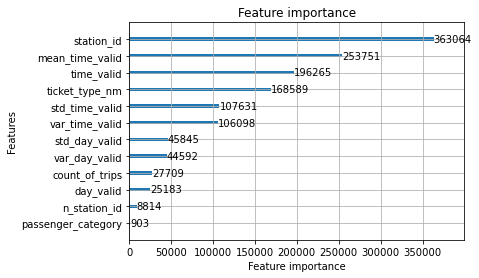

In [72]:
lgbm.plot_importance(model_best)

In [73]:
gc.collect()

0

In [74]:
%%time
y_test_c = model_best.predict(X_test)

CPU times: total: 3h 32min 25s
Wall time: 55min 13s


In [75]:
y_test_c.mean()

11145.981636975208

In [76]:
solution_c = pd.DataFrame(y_test_c, index=X_test.index, columns=['label']).reset_index()

display(solution_c.head())


solution_c.to_csv("amur_sol_c2411_2.csv",sep=",", index=False, line_terminator='\n')

,id,label
0,1091022,2024
1,1091023,3003
2,1091024,2022
3,1091025,2022
4,1091026,2024


## ФИНАЛЬНОЕ ПРЕДСКАЗАНИЕ

In [5]:
s_r = pd.read_csv("/content/drive/MyDrive/amur/amur_sol_3.csv")

In [6]:
s_r.head()

,id,time_to_under
0,1091022,663.242998
1,1091023,345.858138
2,1091024,541.674481
3,1091025,710.153393
4,1091026,623.774560


In [20]:
s_c2 = pd.read_csv("/content/drive/MyDrive/amur/amur_sol_c2411_2.csv")

In [21]:
s_r['label'] = s_c2['label'] 

In [27]:
s_r.head(10)

,id,time_to_under,label
0,1091022,663.242998,2024
1,1091023,345.858138,3003
2,1091024,541.674481,2022
3,1091025,710.153393,2022
4,1091026,623.774560,2024
5,1091027,287.523221,9023
6,1091028,611.463852,2017
7,1091029,112.151689,9006
8,1091030,122.594515,81015
9,1091031,679.170561,2022


In [26]:
s_r.to_csv("/content/drive/MyDrive/amur/amur_final_colution2.csv",sep=",", index=False, line_terminator='\n')

0.323 на паблике